In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score,
                             roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
import warnings

In [4]:
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [7]:
#Loadin Dataset
dataset=pd.read_csv("k2_train.csv")
#Loadin test dataset
test_dataset=pd.read_csv("k2_test.csv")


In [8]:
#checking first 5 rows
dataset.head()

,pl_orbper,pl_orbsmax,pl_rade,pl_masse,pl_radj,pl_massj,pl_dens,pl_orbeccen,pl_insol,pl_eqt,...,pl_orbper_log,pl_insol_log,st_teff_mass_ratio,st_density_approx,sy_pm_log,sy_dist_log,color_bv,color_jh,disposition_binary,disposition_multiclass
0,0.000278,0.014157,0.002307,0.002824,0.002322,0.002824,0.051939,0.090856,0.007786,0.295053,...,0.374276,0.566981,0.108153,0.001575,0.527008,0.358914,0.540028,0.336387,1.0,2.0
1,0.000356,0.014157,0.020743,0.002824,0.020690,0.002824,0.051939,0.090856,0.007786,0.295053,...,0.393125,0.566981,0.060673,0.002148,0.630184,0.393241,0.548228,0.428932,0.0,1.0
2,0.000053,0.012009,0.004913,0.009553,0.004910,0.009553,0.022154,0.178195,0.140246,0.648953,...,0.249801,0.824761,0.065025,0.000082,0.637325,0.441746,0.541557,0.368920,1.0,2.0
3,0.000028,0.014157,0.002029,0.002824,0.002012,0.002824,0.051939,0.090856,0.007786,0.295053,...,0.204540,0.566981,0.112114,0.006436,0.635237,0.301716,0.557818,0.400821,0.0,1.0
4,0.000084,0.014157,0.002013,0.002824,0.002011,0.002824,0.051939,0.090856,0.007786,0.295053,...,0.283840,0.566981,0.096903,0.007601,0.627716,0.448590,0.529534,0.405875,1.0,2.0


In [9]:
#checking shape of dataset
print(f"Shape of dataset is {dataset.shape}")

Shape of dataset is (2395, 62)


In [10]:
# Check target distribution
print(f"\nTarget Distribution:")
print(dataset['disposition_binary'].value_counts())



Target Distribution:
disposition_binary
1.0    1385
0.0    1010
Name: count, dtype: int64


In [11]:
print(f"\nClass Balance:")
print(dataset['disposition_binary'].value_counts(normalize=True))


Class Balance:
disposition_binary
1.0    0.578288
0.0    0.421712
Name: proportion, dtype: float64


In [12]:
#Check for missing values
print(f"\nMissing Values:")
missing = dataset.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values! ✅")



Missing Values:
No missing values! ✅


In [13]:
# Check for infinite values
print(f"\nInfinite Values Check:")
inf_cols = []
for col in dataset.columns:
    if dataset[col].dtype in ['float64', 'int64']:
        if np.isinf(dataset[col]).any():
            inf_cols.append(col)
if inf_cols:
    print(f"Columns with infinite values: {inf_cols}")
else:
    print("No infinite values! ✅")

# Basic statistics
print(f"\nDataset Info:")
print(dataset.info())



Infinite Values Check:
No infinite values! ✅

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395 entries, 0 to 2394
Data columns (total 62 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pl_orbper               2395 non-null   float64
 1   pl_orbsmax              2395 non-null   float64
 2   pl_rade                 2395 non-null   float64
 3   pl_masse                2395 non-null   float64
 4   pl_radj                 2395 non-null   float64
 5   pl_massj                2395 non-null   float64
 6   pl_dens                 2395 non-null   float64
 7   pl_orbeccen             2395 non-null   float64
 8   pl_insol                2395 non-null   float64
 9   pl_eqt                  2395 non-null   float64
 10  pl_orbincl              2395 non-null   float64
 11  pl_tranmid              2395 non-null   float64
 12  pl_imppar               2395 non-null   float64
 13  pl_trandep              2395 non

In [14]:
# Separate features and target
x_train = dataset.drop(["disposition_binary","disposition_multiclass","default_flag","k2_campaigns_num"], axis=1)
y_train = dataset['disposition_binary']
x_test=test_dataset.drop(["disposition_binary","disposition_multiclass","default_flag","k2_campaigns_num"], axis=1)
y_test=test_dataset['disposition_binary']


In [15]:
# Remove constant features (zero variance)
constant_features = [col for col in x_train.columns if x_train[col].nunique() == 1]
if constant_features:
    print(f"Removing {len(constant_features)} constant features...")
    x_train = x_train.drop(columns=constant_features)

print(f"Final Feature Count: {x_train.shape[1]}")

Final Feature Count: 58


In [16]:
#Training multiple models
models = {}
results = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Train and evaluate a model"""
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")

    # Train
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation F1
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring='f1', n_jobs=-1).mean()

    print(f"\n📊 {name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"CV F1 Score: {cv_f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'model': model,
        'accuracy': acc,
        'f1_score': f1,
        'roc_auc': roc,
        'cv_f1': cv_f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [17]:
#Model#1
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    eval_metric='logloss' # Removed early_stopping_rounds
)

results['XGBoost'] = evaluate_model('XGBoost', xgb_model,
                                    x_train, y_train,
                                    x_test, y_test)


Training XGBoost...

📊 XGBoost Results:
Accuracy: 0.9049
F1 Score: 0.9200
ROC-AUC: 0.9710
CV F1 Score: 0.9135

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       337
         1.0       0.90      0.95      0.92       462

    accuracy                           0.90       799
   macro avg       0.91      0.90      0.90       799
weighted avg       0.91      0.90      0.90       799



In [18]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    verbose=-1
)

results['LightGBM'] = evaluate_model('LightGBM', lgb_model,
                                     x_train, y_train,
                                     x_test, y_test)



Training LightGBM...

📊 LightGBM Results:
Accuracy: 0.9099
F1 Score: 0.9245
ROC-AUC: 0.9732
CV F1 Score: 0.9225

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89       337
         1.0       0.90      0.95      0.92       462

    accuracy                           0.91       799
   macro avg       0.91      0.90      0.91       799
weighted avg       0.91      0.91      0.91       799



In [19]:
catboost_model = CatBoostClassifier(
    iterations=500,
    depth=7,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_state=RANDOM_STATE,
    verbose=False
)

results['CatBoost'] = evaluate_model('CatBoost', catboost_model,
                                     x_train, y_train,
                                     x_test, y_test)


Training CatBoost...

📊 CatBoost Results:
Accuracy: 0.9111
F1 Score: 0.9255
ROC-AUC: 0.9749
CV F1 Score: 0.9205

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89       337
         1.0       0.90      0.95      0.93       462

    accuracy                           0.91       799
   macro avg       0.91      0.90      0.91       799
weighted avg       0.91      0.91      0.91       799



In [20]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

results['Random Forest'] = evaluate_model('Random Forest', rf_model,
                                          x_train, y_train,
                                          x_test, y_test)



Training Random Forest...

📊 Random Forest Results:
Accuracy: 0.8924
F1 Score: 0.9102
ROC-AUC: 0.9603
CV F1 Score: 0.9057

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.87       337
         1.0       0.88      0.94      0.91       462

    accuracy                           0.89       799
   macro avg       0.90      0.88      0.89       799
weighted avg       0.89      0.89      0.89       799



In [21]:
print("\n" + "="*80)
print("🏆 MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1 Score': [results[m]['f1_score'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results],
    'CV F1': [results[m]['cv_f1'] for m in results]
})

comparison_df = comparison_df.sort_values('F1 Score', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Select best model based on F1 score (important for imbalanced data)
best_model_name = comparison_df.iloc[0]['Model']
best_model_result = results[best_model_name]
best_model = best_model_result['model']

print(f"\n🌟 Best Model: {best_model_name}")
print(f"   Accuracy: {best_model_result['accuracy']:.4f}")
print(f"   F1 Score: {best_model_result['f1_score']:.4f}")
print(f"   ROC-AUC: {best_model_result['roc_auc']:.4f}")



🏆 MODEL COMPARISON

         Model  Accuracy  F1 Score  ROC-AUC    CV F1
     CatBoost  0.911139  0.925498 0.974867 0.920502
     LightGBM  0.909887  0.924528 0.973230 0.922453
      XGBoost  0.904881  0.920000 0.970969 0.913528
Random Forest  0.892365  0.910230 0.960320 0.905740

🌟 Best Model: CatBoost
   Accuracy: 0.9111
   F1 Score: 0.9255
   ROC-AUC: 0.9749



📈 Creating visualizations...


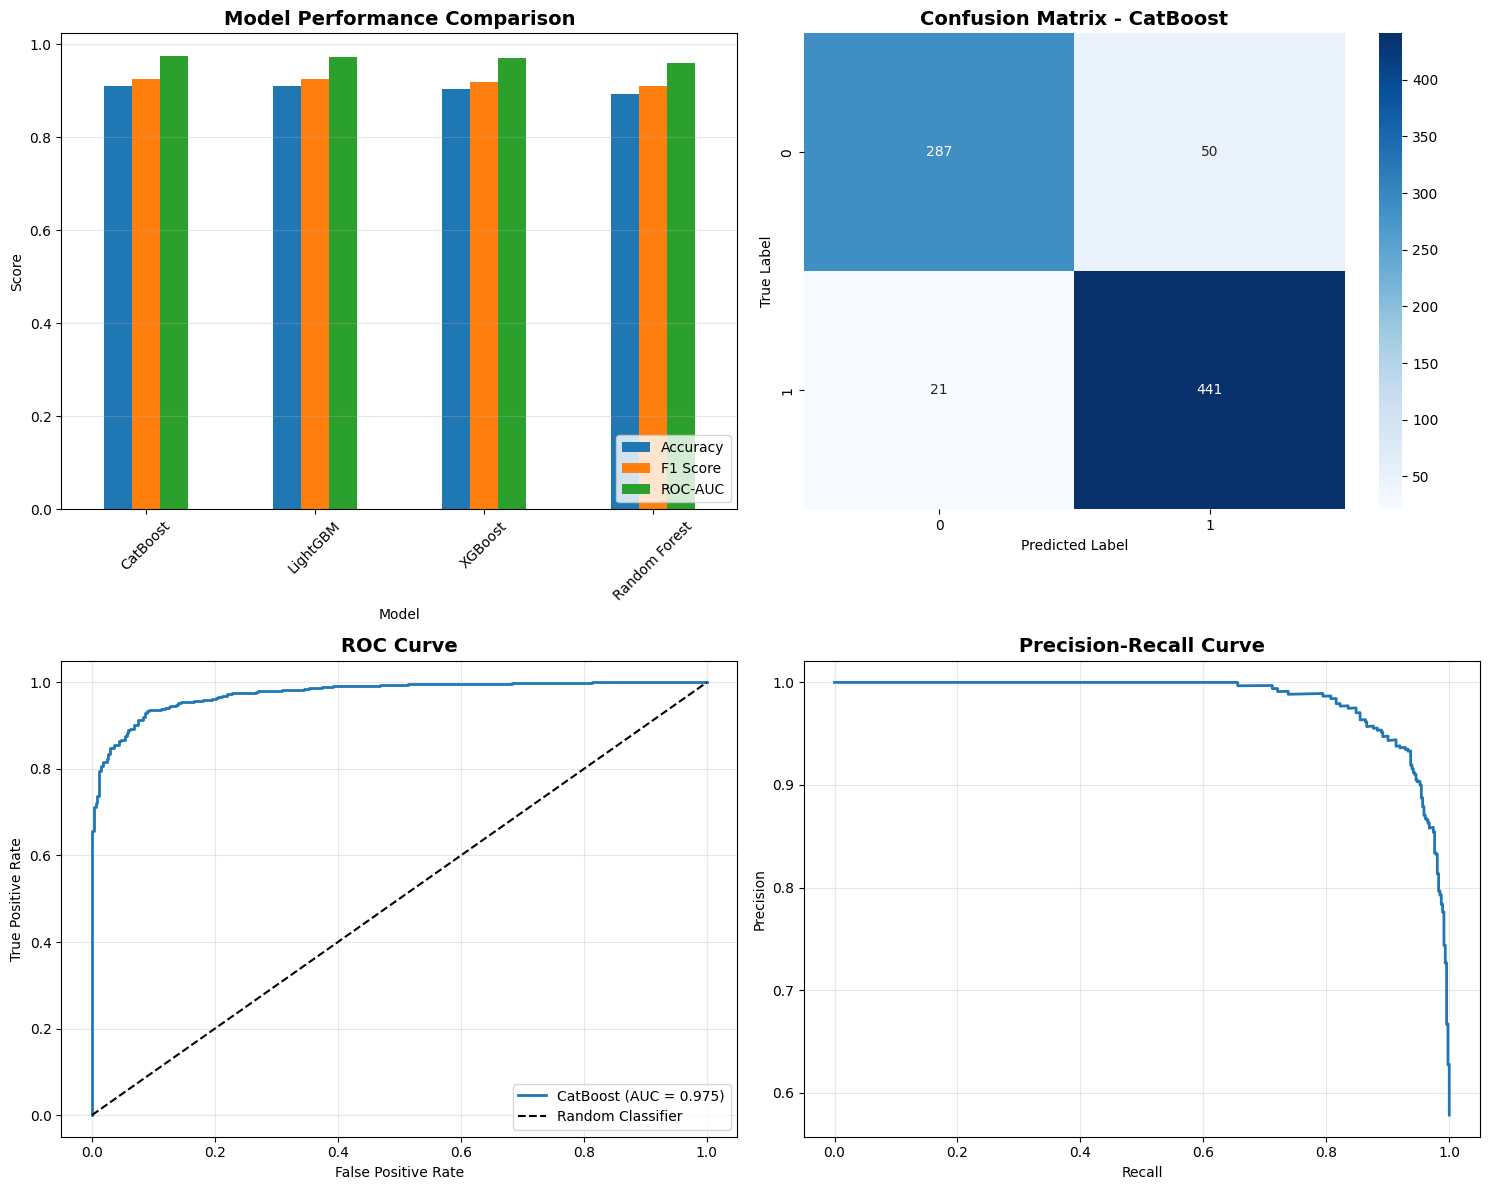

✅ Visualizations saved as 'exoplanet_model_results.png'


In [22]:
print("\n📈 Creating visualizations...")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Comparison Bar Plot
ax1 = axes[0, 0]
comparison_df.set_index('Model')[['Accuracy', 'F1 Score', 'ROC-AUC']].plot(
    kind='bar', ax=ax1, rot=45
)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)

# 2. Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, best_model_result['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
ax3 = axes[1, 0]
fpr, tpr, _ = roc_curve(y_test, best_model_result['y_pred_proba'])
ax3.plot(fpr, tpr, label=f'{best_model_name} (AUC = {best_model_result["roc_auc"]:.3f})', linewidth=2)
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Precision-Recall Curve
ax4 = axes[1, 1]
precision, recall, _ = precision_recall_curve(y_test, best_model_result['y_pred_proba'])
ax4.plot(recall, precision, linewidth=2)
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('exoplanet_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved as 'exoplanet_model_results.png'")


📊 Top 20 Most Important Features:
             feature  importance
pl_radius_comparison    7.271140
              sy_plx    5.136061
          pl_trandep    5.008782
          pl_trandur    4.701829
          pl_tranmid    3.894393
                glon    3.827184
            color_bv    3.582167
           pl_ratror    3.135247
           pl_orbper    2.859387
             sy_pmra    2.755299
           sy_pm_log    2.707105
                glat    2.656284
       pl_orbper_log    2.544739
             sy_dist    2.509878
               sy_pm    2.486635
            color_jh    2.396469
            sy_pmdec    2.359935
    pl_density_ratio    2.276751
          pl_orbsmax    2.090263
         sy_dist_log    1.670961


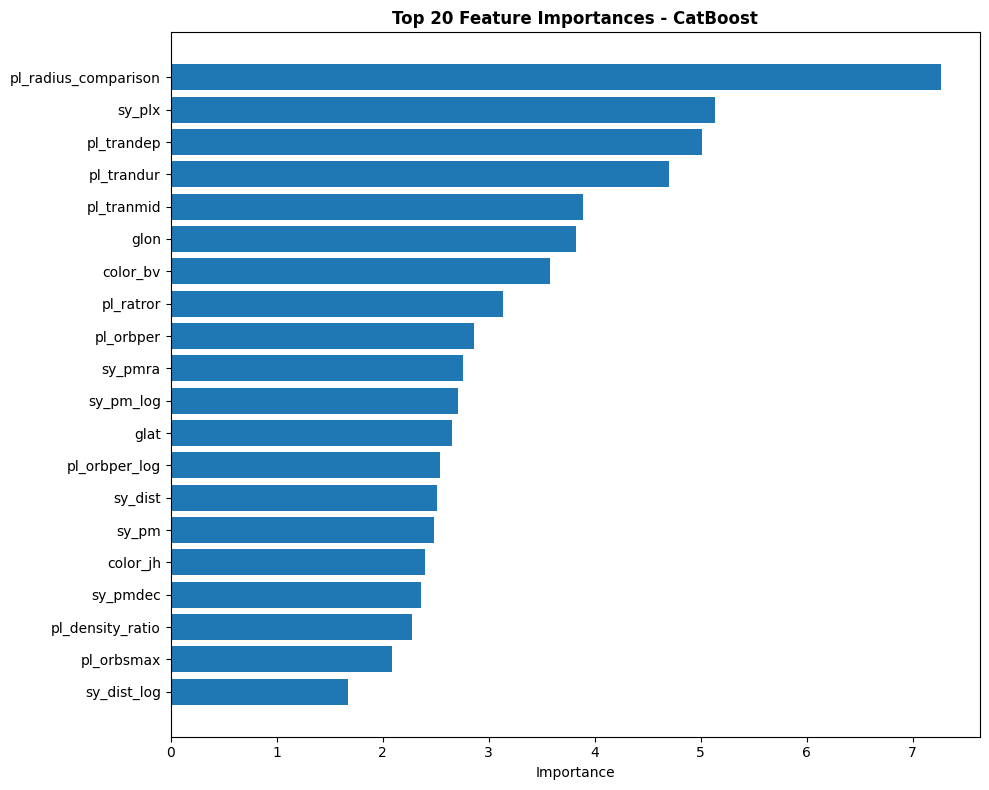

✅ Feature importance saved as 'feature_importance.png'


In [23]:
if hasattr(best_model, 'feature_importances_'):
    print("\n📊 Top 20 Most Important Features:")

    feature_importance = pd.DataFrame({
        'feature': x_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(20).to_string(index=False))

    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Feature importance saved as 'feature_importance.png'")


In [ ]:
# CATBOOST Performing very well among other models so we are using it to make predictio after successfully runing all cell you will have test prediction.csv,exoplanet_model_results.png,, best_exoplanet_model_catboost in your directory.

In [24]:
import joblib
import pickle

# Save the best model
joblib.dump(best_model, f'best_exoplanet_model_{best_model_name.replace(" ", "_")}.pkl')
print(f"✅ Best model saved as: best_exoplanet_model_{best_model_name.replace(' ', '_')}.pkl")


# Save predictions
predictions_df = pd.DataFrame({
    'true_label': y_test.values,
    'predicted_label': best_model_result['y_pred'],
    'prediction_probability': best_model_result['y_pred_proba']
})
predictions_df.to_csv('test_predictions.csv', index=False)
print("✅ Test predictions saved as: test_predictions.csv")

✅ Best model saved as: best_exoplanet_model_CatBoost.pkl
✅ Test predictions saved as: test_predictions.csv
